In [4]:
import os
import time
import matplotlib.pyplot as plt

from monai.config import print_config
from monai.data import DataLoader, decollate_batch, Dataset, ArrayDataset
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,

    AsDiscrete,
    AsDiscreted,
    Compose,
 
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    CropForegroundd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    SpatialPadd,
    SpatialCropd,
    ScaleIntensityd,
    ShiftIntensityd,
    ResizeD,
    AdjustContrastd,
    RandGaussianSharpend,
    RandHistogramShiftd,
    RandStdShiftIntensityd,
    RandAdjustContrastd
    
)
from monai.utils import set_determinism
import numpy as np
import torch

import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.nets import SegResNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Activations, AsDiscrete
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset
from monai.utils import set_determinism
import os
import nibabel as nib
import numpy as np

import torch
from monai.transforms import Transform, Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, NormalizeIntensityd, ResizeD
from monai.transforms import (
    AsDiscreted,
    Compose,

    LoadImaged,

)

import os
from monai.transforms import Compose, LoadImaged, AddChanneld, ScaleIntensityRanged, ToTensord

print_config()



MONAI version: 1.1.0
Numpy version: 1.23.5
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /usr/local/lib/python3.8/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.12
Nibabel version: 5.1.0
scikit-image version: 0.20.0
Pillow version: 9.5.0
Tensorboard version: 2.12.3
gdown version: 4.7.1
TorchVision version: 0.15.2+cu117
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.5
pandas version: 2.0.1
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.3.2
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [5]:
data_dir =  "/home/Task07_Pancreas/"
images_dir = os.path.join(data_dir, "imagesTr")
labels_dir = os.path.join(data_dir, "labelsTr")

In [9]:
# Get image and label file paths
image_files = sorted([os.path.join(images_dir, x) for x in os.listdir(images_dir) if x.endswith(".nii.gz")])
label_files = sorted([os.path.join(labels_dir, x) for x in os.listdir(labels_dir) if x.endswith(".nii.gz")])


In [10]:
# Make sure the images and labels correspond correctly
assert len(image_files) == len(label_files)
for im, lab in zip(image_files, label_files):
    assert os.path.splitext(os.path.basename(im))[0] == os.path.splitext(os.path.basename(lab))[0]


In [12]:
# Determine the number of samples to load
num_samples_to_load = len(image_files) // 6

# Create a list of dictionaries where each dictionary represents one sample
data_dicts = [{"image": image, "label": label} for image, label in zip(image_files[:num_samples_to_load], label_files[:num_samples_to_load])]


In [47]:
class ConvertToSingleLabel(Transform):
    def __call__(self, data):
        label = data["label"]
        # Single-channel label, convert to three-channel
        multiclass_label = torch.zeros(1, *label.shape[1:], dtype=torch.float32)
   
        multiclass_label[0] = (label[0] == 1).float()  # category 1


        data["label"] = multiclass_label
        return data

In [48]:
# Define your transforms
transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    AddChanneld(keys=["image", "label"]),
    ConvertToSingleLabel(),  # Convert label to multi-class format with three channels
    ScaleIntensityRanged(keys="image", a_min=-57, a_max=164, b_min=0.0, b_max=1.0, clip=True),
    # AsDiscreted(keys='label', to_onehot=3),
    CropForegroundd(keys=["image", "label"], source_key="image"),  # Crop the foreground of the image and label
    Spacingd(keys=["image", "label"], pixdim=[1.0, 1.0, 1.0]),

    ResizeD(keys=["image", "label"], spatial_size=[224, 224, 144], mode=("trilinear", "nearest")),  # Resize image and label
    ToTensord(keys=["image", "label"]),
    
])

In [49]:
dataset = Dataset(data=data_dicts, transform=transforms)

In [50]:
# Define sizes for training and validation datasets
num_samples = len(dataset)
num_train = 25
num_val = 15

In [51]:
# Ensure we're not trying to create a validation set larger than the dataset
assert num_train + num_val <= num_samples, "Not enough samples in the dataset"


In [52]:
# Split the dataset
train_indices = list(range(num_train))
val_indices = list(range(num_train, num_train + num_val))

In [53]:
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

In [54]:
# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [55]:
# Get the first sample in the dataset
first_sample = train_dataset[0]

image_shape = first_sample['image'].shape
label_shape = first_sample['label'].shape

print(f"Image shape: {image_shape}")
print(f"Label shape: {label_shape}")


Image shape: torch.Size([1, 224, 224, 144])
Label shape: torch.Size([1, 224, 224, 144])


In [56]:
label_tensor = first_sample['label']  # Assuming you have already obtained the label tensor
unique_labels = torch.unique(label_tensor)

print("Unique Labels:", unique_labels)

Unique Labels: tensor([0., 1.])


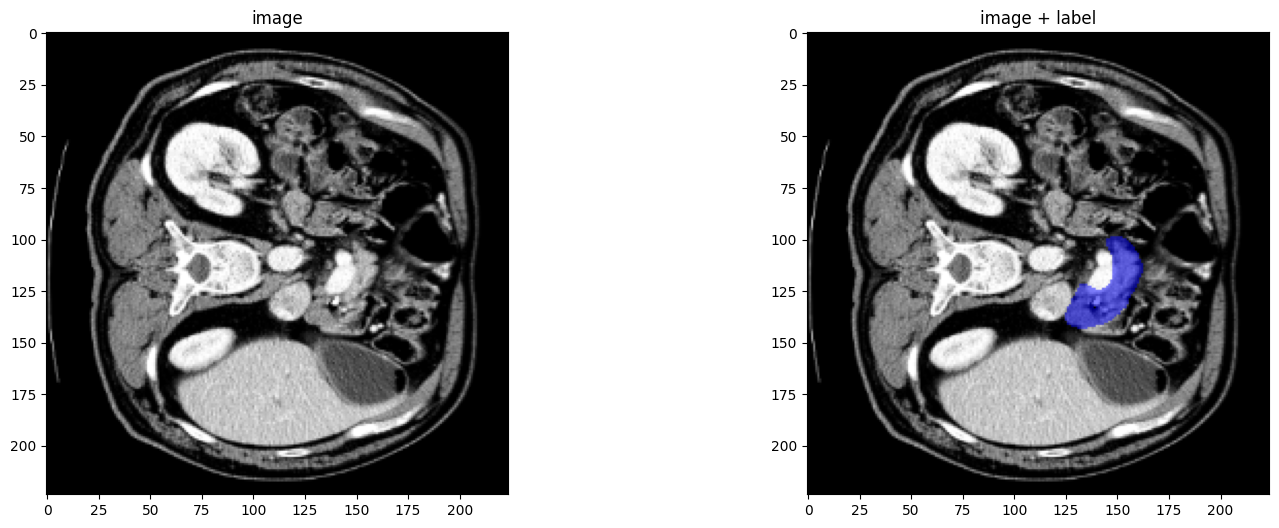

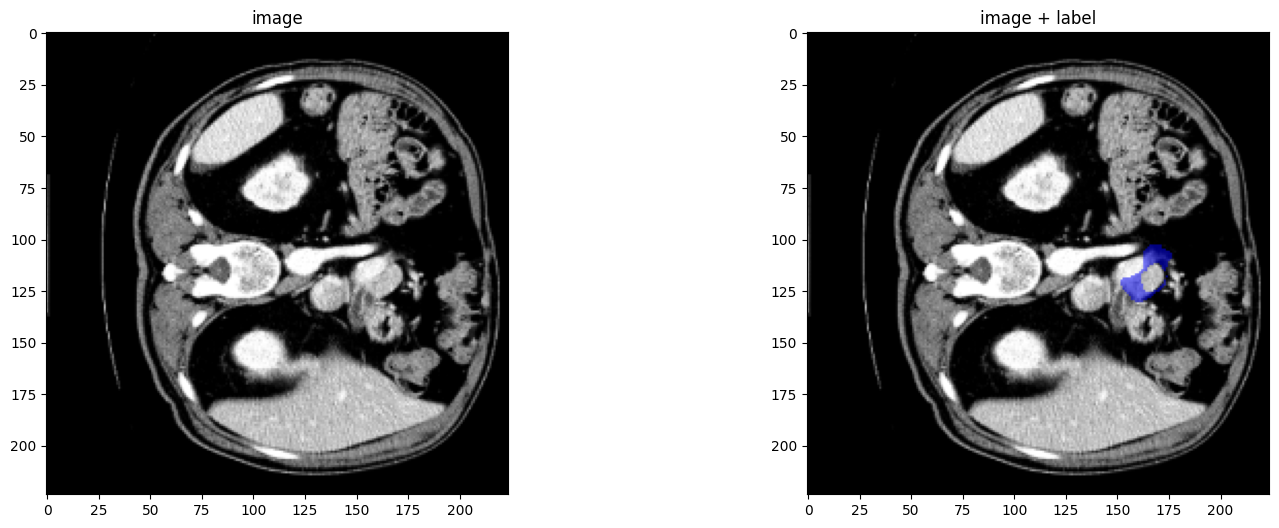

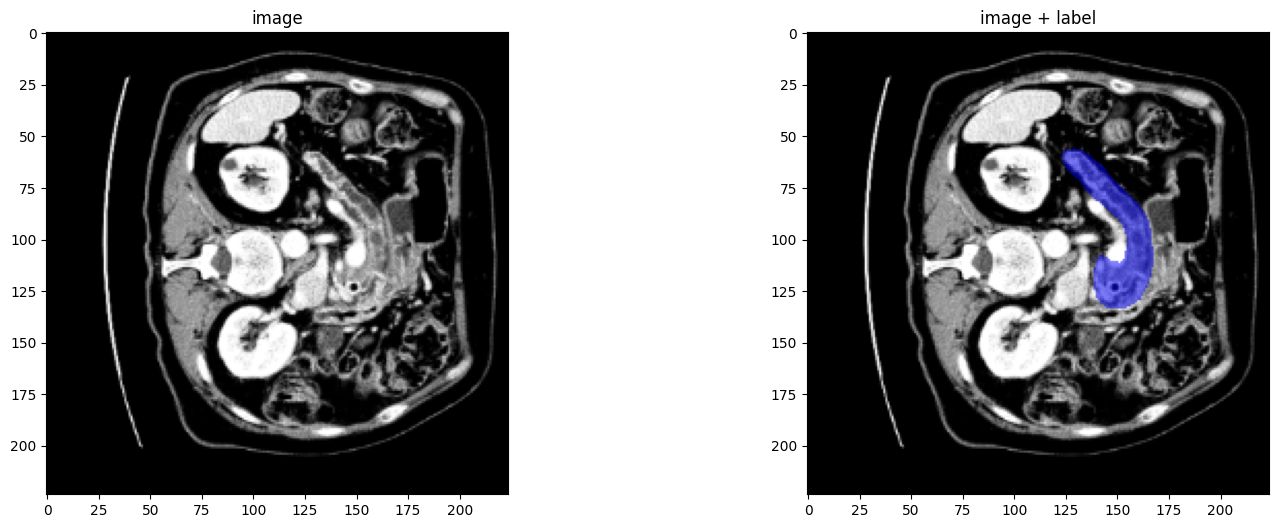

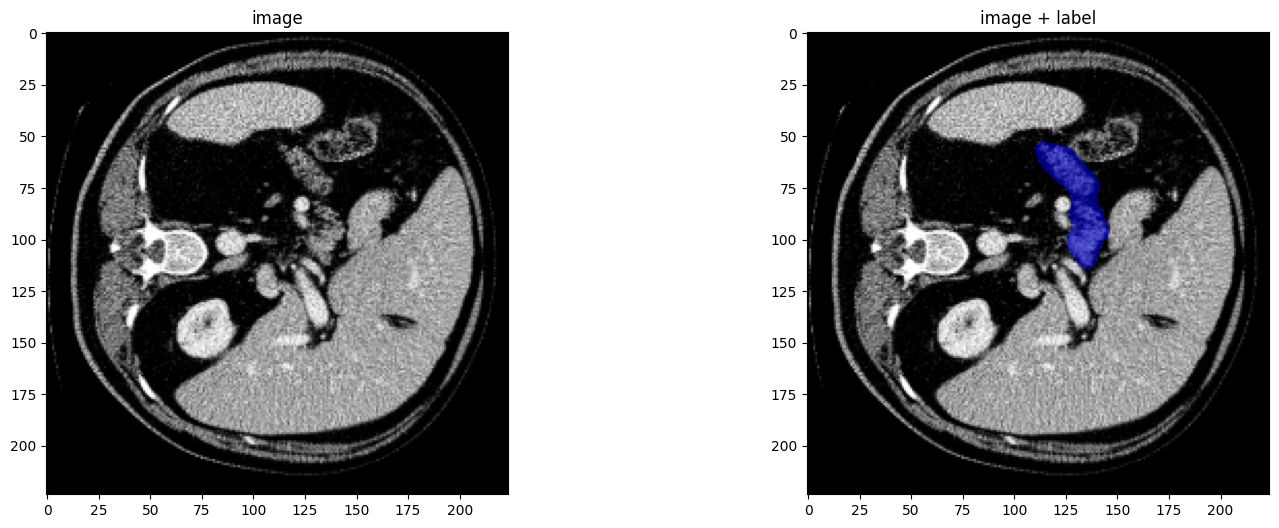

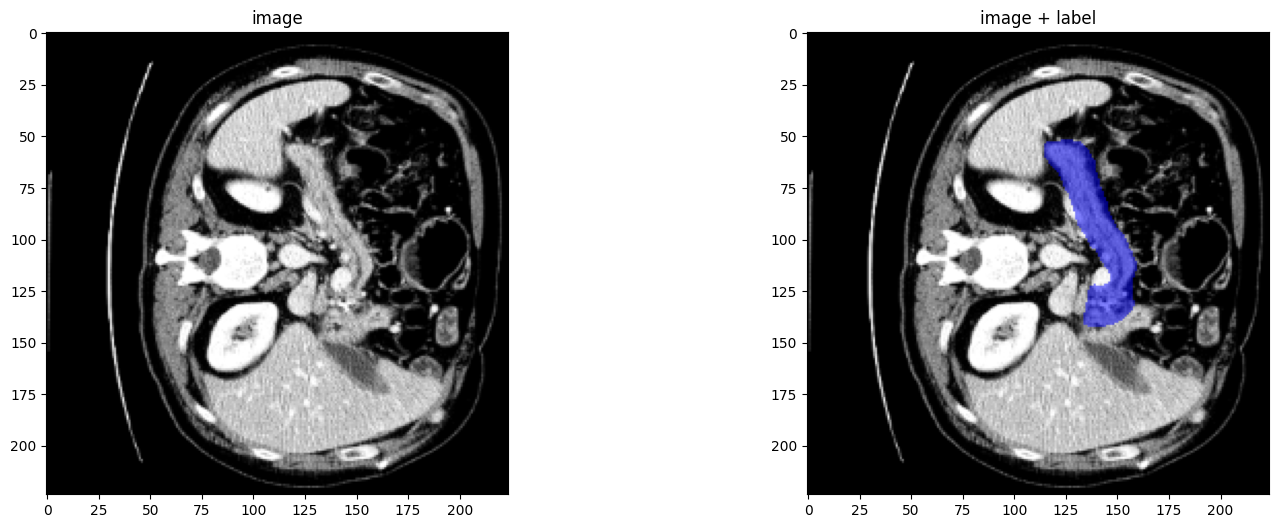

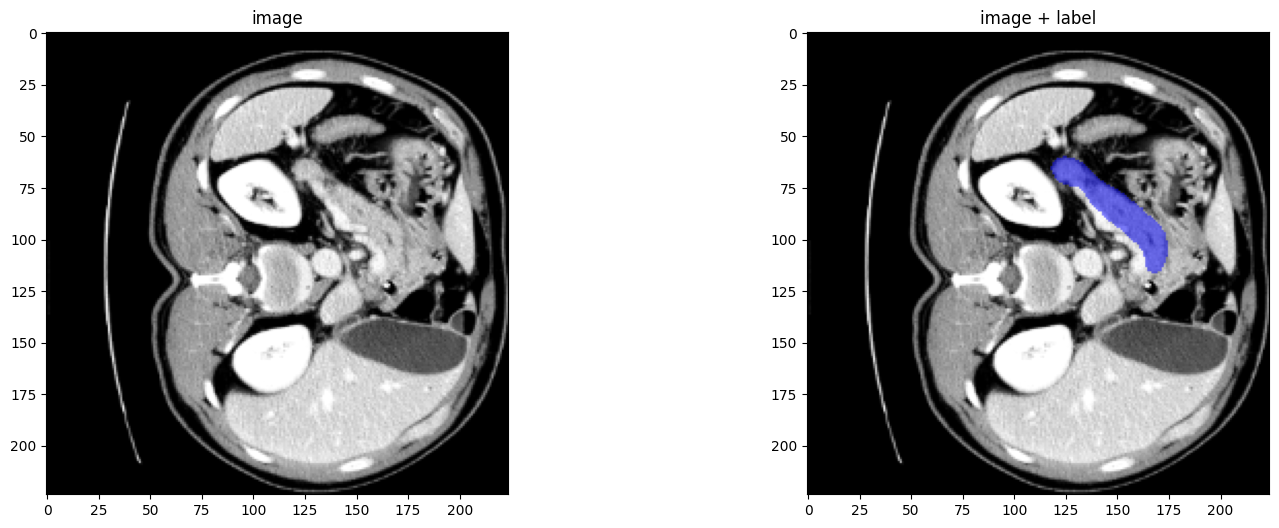

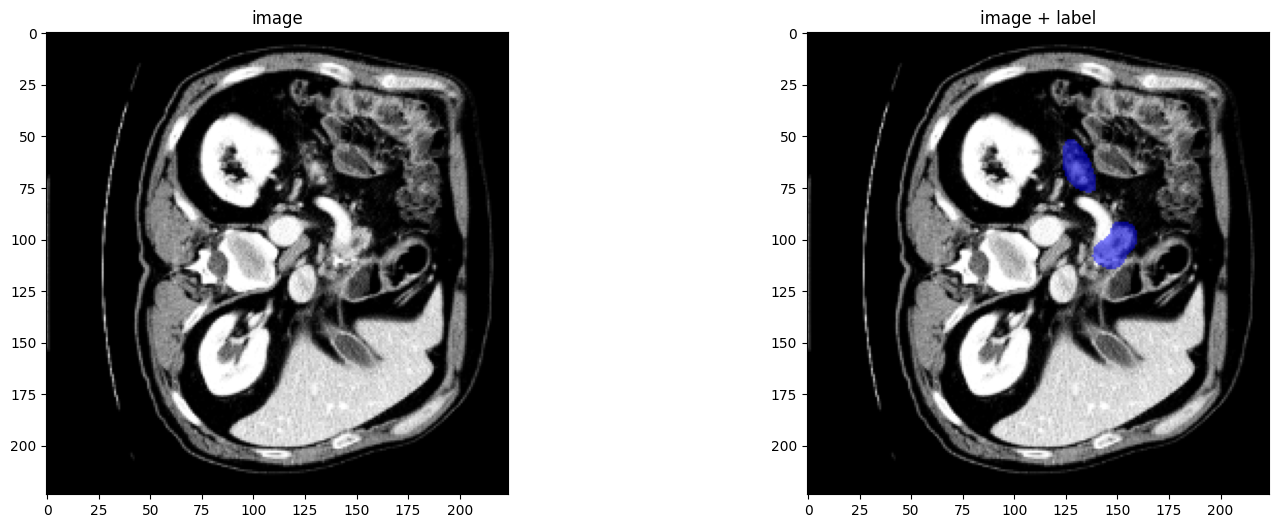

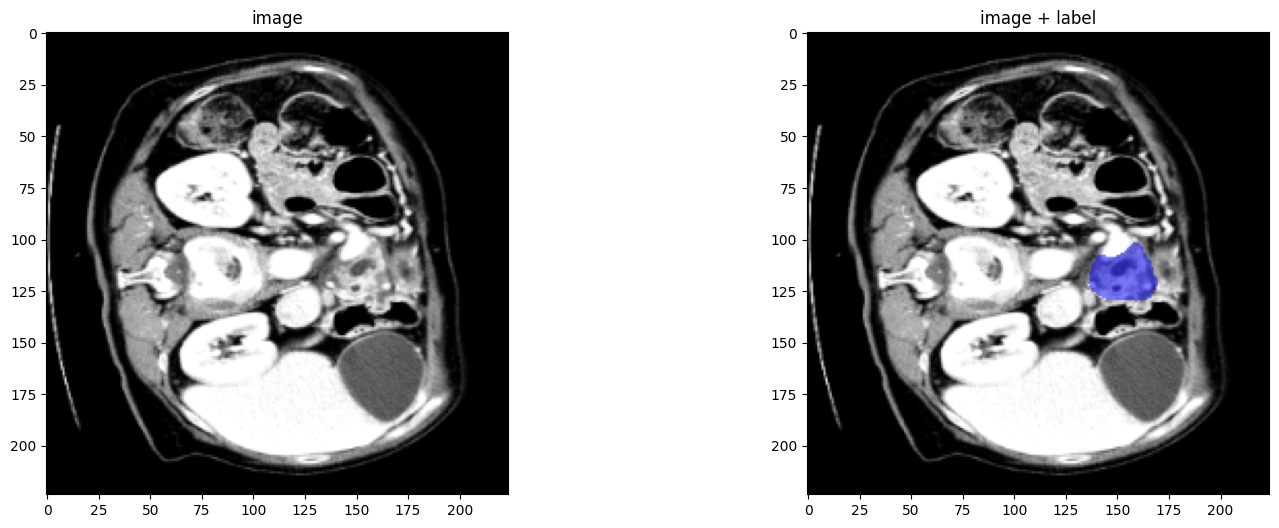

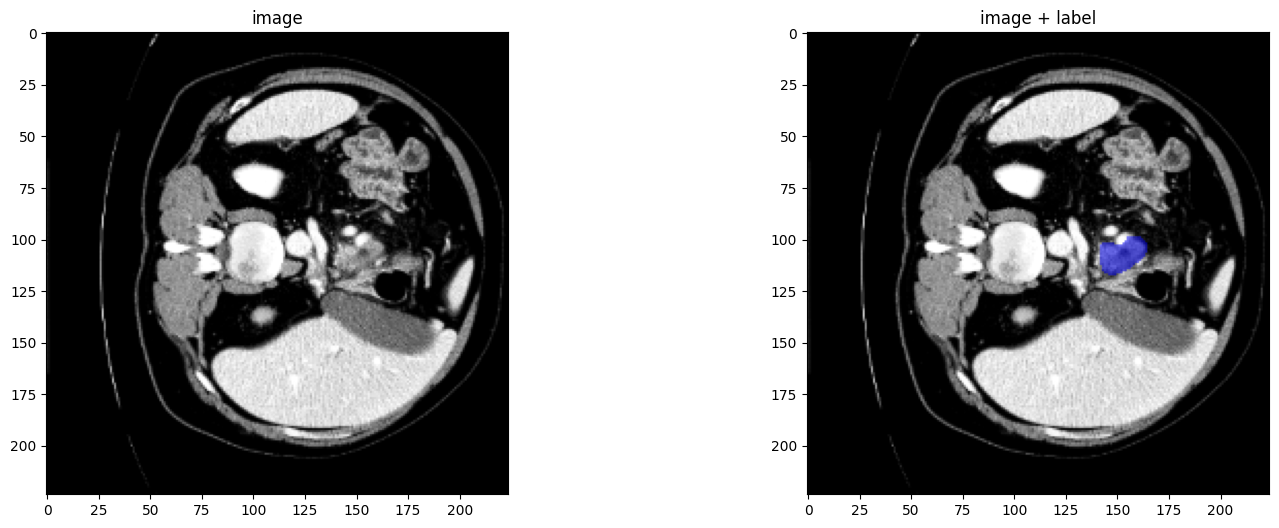

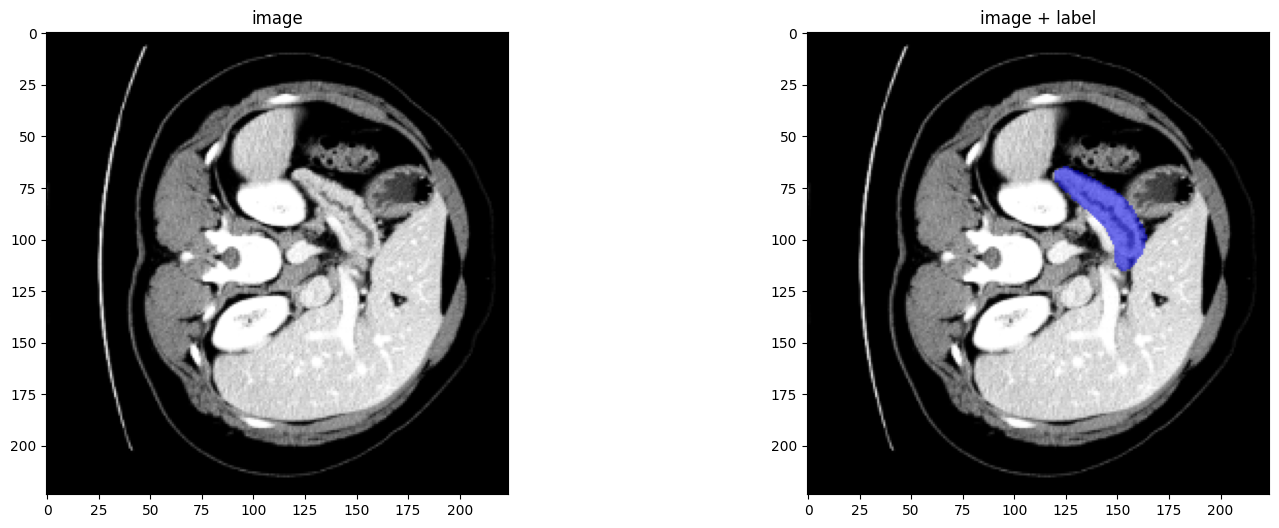

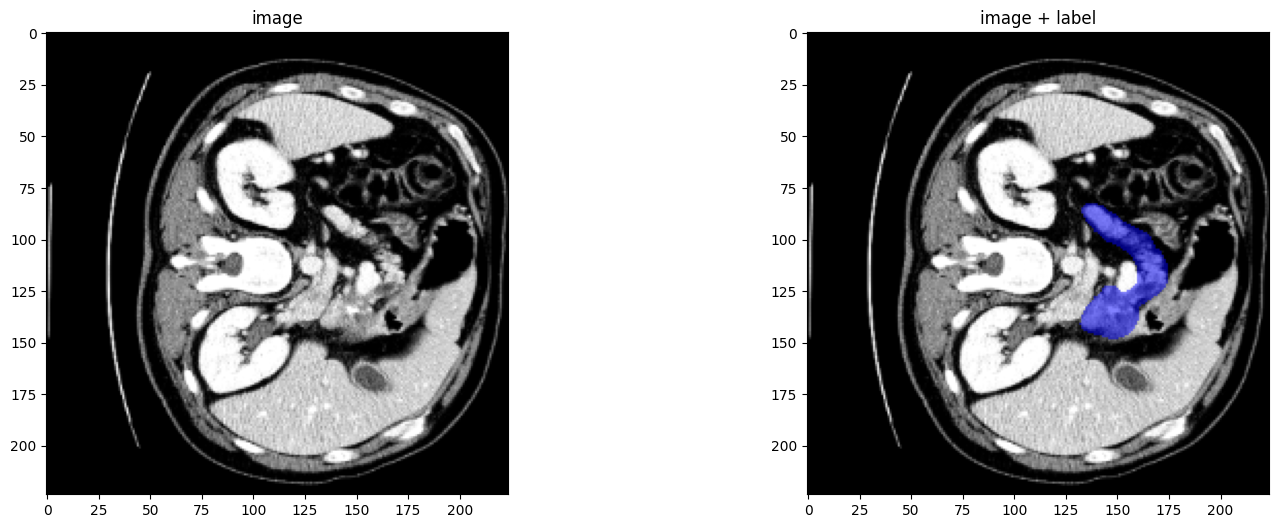

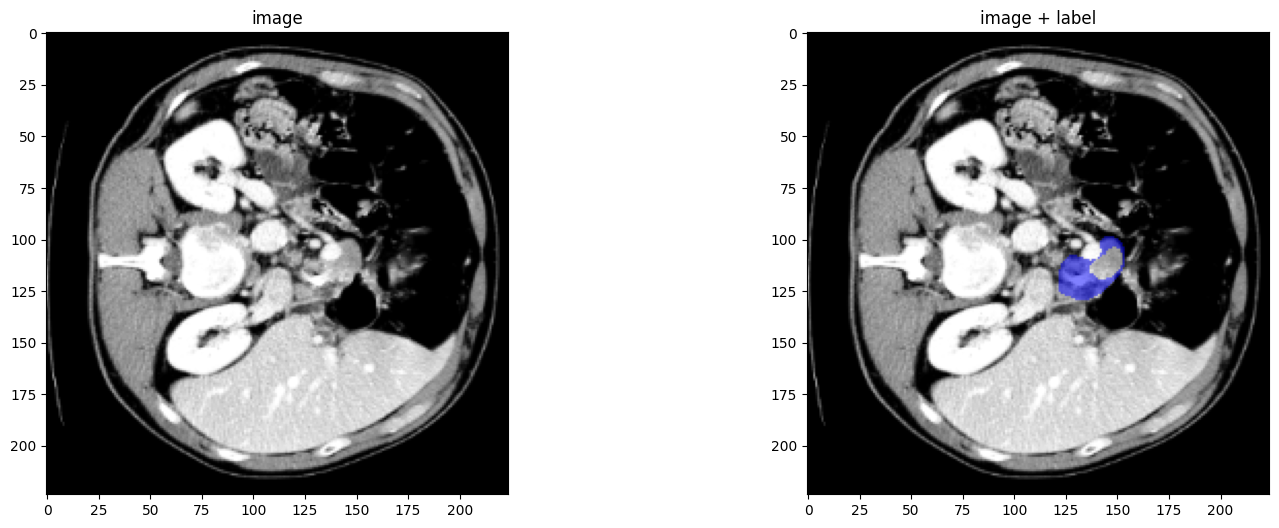

In [57]:
colors = [(0, 0, 1, i) for i in np.linspace(0, 1, 100)]
blue_cmap = mcolors.LinearSegmentedColormap.from_list('blue_alpha', colors)

for i in range(1, 13):                                               
    val_data_example = train_dataset[i]
    # Select a slice to visualize (e.g., the middle slice)
    slice_idx = val_data_example['image'].shape[3] // 2  # adjust to the depth dimension

    # Get image and label
    image = val_data_example['image'][0, :, :, slice_idx].detach().cpu()
    label = val_data_example['label'][0, :, :, slice_idx].detach().cpu()  # Use label index 0

    # Create a figure
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image, cmap='gray')

    # Overlay the label
    plt.subplot(1, 2, 2)
    plt.title("image + label")
    plt.imshow(image, cmap='gray')
    plt.imshow(label, cmap=blue_cmap, alpha=0.5)  # Use alpha for transparency

    plt.show()


In [64]:
# Define your UNet model as a function
def unet(in_channels, out_channels):
    model = SegResNet(
        blocks_down=[1, 2, 2, 4],
        blocks_up=[1, 1, 1],
        init_filters=16,
        in_channels=in_channels,
        out_channels=out_channels,
        dropout_prob=0.2,
    )
    return model.half()

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [66]:
# Define your UNet model
in_channels = 1
out_channels = 1  # Set the output channels to 1 for pancreas detection
model = unet(in_channels, out_channels)

# Rest of the code
max_epochs = 300
val_interval = 1
VAL_AMP = True

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

scaler = torch.cuda.amp.GradScaler(enabled=VAL_AMP)  # Enable mixed-precision training
torch.backends.cudnn.benchmark = True

In [67]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
max_epochs = 100

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            inputs = inputs.half()
            outputs = model(inputs)
            loss = loss_function(outputs, labels.float())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_dataset) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_inputs = val_inputs.half()
                val_labels = val_labels.float()
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                # torch.save(
                #     model.state_dict(),
                #     os.path.join(root_dir, "best_metric_model.pth"),
                # )
                # print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

# Calculate the mean dice score
mean_dice_score = metric_values[-1]
print(f"Mean Dice Score: {mean_dice_score:.4f}")

----------
epoch 1/100


RuntimeError: Input type (torch.cuda.HalfTensor) and weight type (torch.HalfTensor) should be the same